In [1]:
import pickle, math

import h5py
import numpy as np
import scipy as sp
import tensorflow_datasets as tfds
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
import seaborn as sns

# Style settings
sns.set_theme(style='ticks', font_scale=1.3)
plt.rcParams['text.usetex'] = True
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + [mcolors.to_rgba(mcolors.CSS4_COLORS['lime']), mcolors.to_rgba(mcolors.CSS4_COLORS['sandybrown'])]
sns_blue = sns.color_palette().as_hex()[0]

from src import mnist_train

from importlib import reload
reload(mnist_train);

## Distances

{'batch_size': 5000, 'epochs': 1000, 'eps': 1e-08, 'lrs': array([1.0e-03, 1.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 1.5e+01]), 'n_init': 20, 'n_pert': 10, 'train_size': 5000}
[1.0e-03 1.0e-02 1.0e-01 1.0e+00 5.0e+00 1.5e+01]


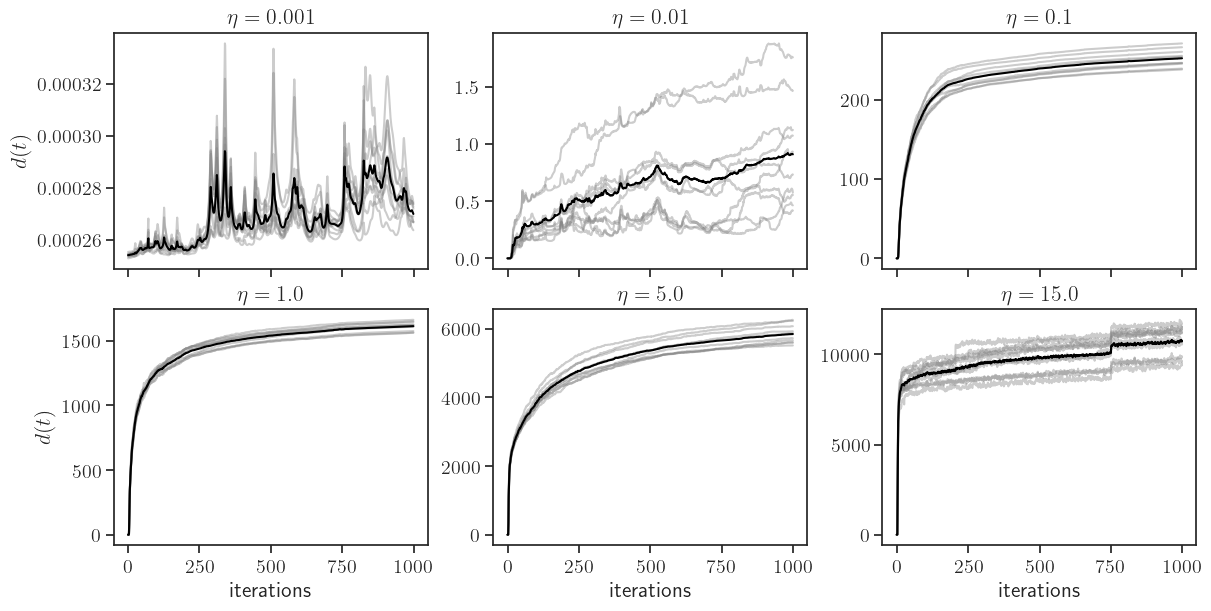

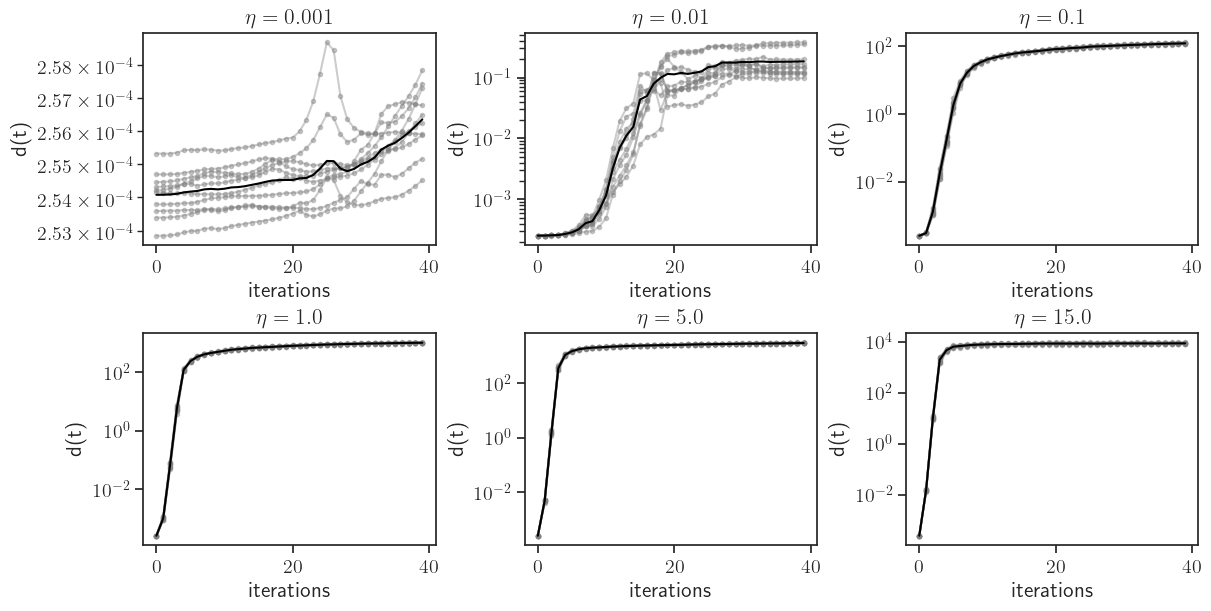

In [2]:
with h5py.File('results/mnist_lr.h5', 'r') as f :
    print(dict(f.attrs))
    print(f.attrs['lrs'])

    # print(f['weights'][2,1,5,1])
    # print(f['dists'][:,0,0,:5])
    # print(f['loss_train'][0,:,0,:10])

    i_init = 8
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='constrained', sharex=True)
    axs_flat = axs.flatten()
    for i_lr, lr in enumerate(f.attrs['lrs']) :
        ax = axs_flat[i_lr]
        lr_dists = f['dists'][i_lr,i_init,:,:].T
        ax.plot(lr_dists, color='gray', alpha=0.4)
        ax.plot(np.mean(lr_dists, axis=1), color='black')
        ax.set_title(f"$\eta = {f.attrs['lrs'][i_lr]}$")
    axs[1,0].set_xlabel("iterations")
    axs[1,1].set_xlabel("iterations")
    axs[1,2].set_xlabel("iterations")
    axs[0,0].set_ylabel("$d(t)$")
    axs[1,0].set_ylabel("$d(t)$")
    plt.savefig('figures/mnist_dists.png', dpi=160, bbox_inches='tight')
        
    fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='constrained')
    axs_flat = axs.flatten()
    lim = 40
    lims = [lim] * 6
    lims[0] = 100
    for i_lr, lr in enumerate(f.attrs['lrs']) :
        ax = axs_flat[i_lr]
        lr_dists = f['dists'][i_lr,i_init,:,:lim].T
        ax.plot(lr_dists, '.-', color='gray', alpha=0.4)
        ax.plot(np.mean(lr_dists, axis=1), color='black')
        ax.set_title(f"$\eta = {f.attrs['lrs'][i_lr]}$")
        ax.set_yscale('log')
        ax.set_xlabel("iterations")
        ax.set_ylabel("d(t)")

### Limit $\epsilon \to 0$

{'batch_size': 5000, 'epochs': 100, 'eps': 1e-08, 'lrs': array([0.01, 1.  , 2.  , 5.  ]), 'n_init': 20, 'n_pert': 16, 'n_wi': array([    1,     2,     4,     8,    16,    32,    64,   128,   256,
         512,  1024,  2048,  4096,  8192, 16384, 32768]), 'train_size': 5000}
(4, 20, 16, 100)


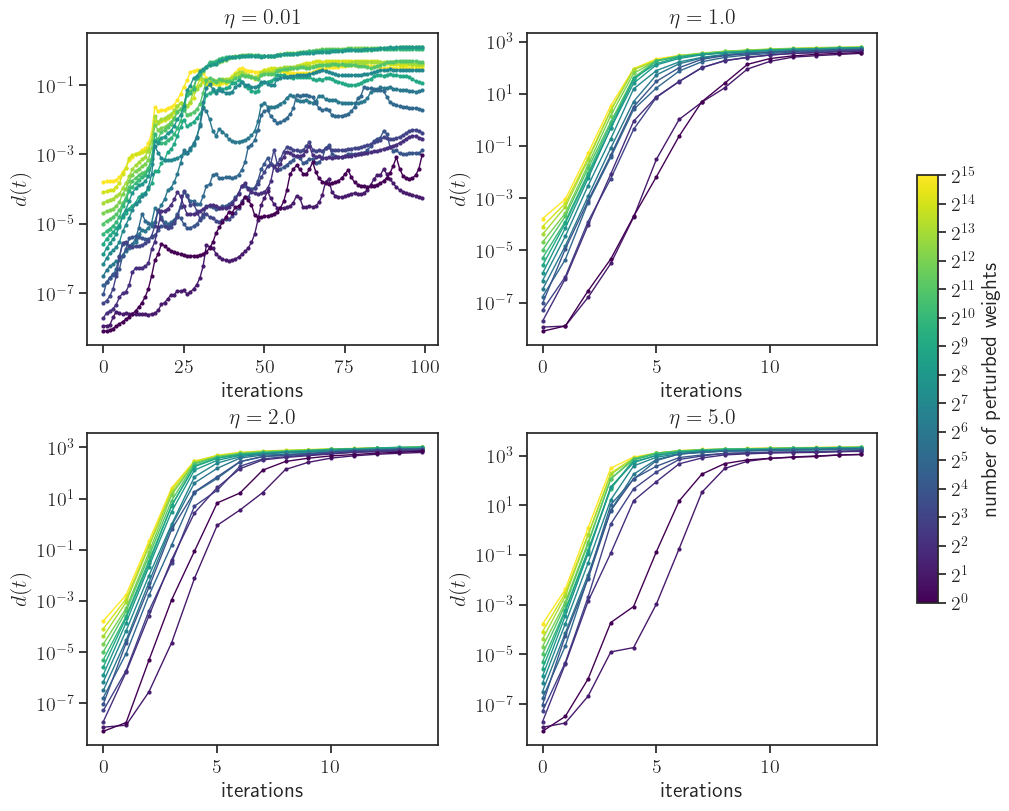

In [3]:
with h5py.File('results/mnist_epsilon_limit.h5', 'r') as f :
    print(dict(f.attrs))
    print(f['dists'].shape)

    dists_ds = f['dists']

    i_init = 4
    lim = 15   # max 100
    lims = [100, lim, lim, lim]   # max 100

    n_wi = f.attrs['n_wi']
    cmap = mpl.colormaps['viridis']
    # cmap = mpl.colormaps['copper']
    norm = mpl.colors.SymLogNorm(linthresh=0.1, vmin=n_wi[0], vmax=n_wi[-1], base=2)

    fig, axs = plt.subplots(2, 2, figsize=(10,8), layout='constrained')
    axs_flat = axs.flatten()
    for i_lr, lr in enumerate(f.attrs['lrs']) :
        ax = axs_flat[i_lr]
        for i_n, n in enumerate(n_wi[::-1]) :
            color = cmap(norm(n))
            # plt.plot(dists_ds[i_lr,i_init,i_n,:lim].T, '.-', color=color)
            ax.plot(dists_ds[i_lr,i_init,len(n_wi)-1-i_n,:lims[i_lr]].T, '.-', ms=4, lw=1, color=color)
        # plt.plot(np.mean(dists_ds[i_lr,i_init,-1,:lim].T, axis=1), '.-', color='black')
        ax.set(xlabel='iterations', ylabel='$d(t)$', yscale='log', title=f'$\eta={lr}$')
    # axs_flat[0].set_yscale('linear')
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label="number of perturbed weights", ax=axs, shrink=0.6)

    plt.savefig('figures/mnist_dists_eps_limit.png', dpi=160, bbox_inches='tight')

**Caveat for above**: perturbation are only on hidden layer weights

Interestingly, seems like for some perturbation ranges the low LR regime also exhibits a phase of exponential divergence.

### What causes explosion?

In [50]:
with h5py.File('results/mnist_explosion.h5', 'r') as f :
    print(dict(f.attrs))

    h_dim = 64
    N = 784 * h_dim + h_dim + h_dim * 10 + 10
    dists_ds = f[f'h_dim_{h_dim}']['dists']
    print(dists_ds.shape)

    dist_jumps = (dists_ds[...,1] - dists_ds[...,0]) / N
    print(dist_jumps)
    print(f"Total number of param combinations: {dist_jumps.size}")
    d = 10**-4
    print(f"Jumps larger than {d} : {np.sum(dist_jumps > d)}")

{'activations': array(['sigmoid', 'tanh', 'relu'], dtype=object), 'epochs': 2, 'epsilons': array([1.e-12, 1.e-08, 1.e-04]), 'h_dims': array([16, 32, 64]), 'lrs': array([1.e-03, 1.e-02, 1.e+00, 2.e+00, 5.e+00]), 'n_init': 5, 'n_pert': 10, 'train_sizes': array([   10,   100,  1000, 10000])}
(5, 3, 4, 3, 5, 10, 2)
[[[[[[ 3.29269880e-17  1.69625748e-17  5.87032049e-19 ...
       1.00257685e-16 -5.22073164e-18 -5.55780125e-18]
     [ 3.66119677e-16  3.52253629e-16 -1.95219650e-18 ...
       2.79703402e-16  2.15372282e-17  3.64220680e-16]
     [ 8.76411129e-15  6.75738505e-15  1.26643715e-14 ...
       4.05131906e-15  1.39757710e-14  3.05532952e-15]
     [ 1.53063624e-16  2.47087823e-17  1.39735362e-16 ...
       1.68946811e-17 -2.27424866e-17  4.15898393e-17]
     [ 7.04548413e-17  3.15225563e-16  2.68151832e-18 ...
       2.34837346e-15  1.79044549e-15  1.72541122e-16]]

    [[-1.64531207e-19 -9.66779445e-20 -1.49817792e-19 ...
      -2.35461054e-19 -1.25096010e-19 -1.30532775e-19]
     [ 

## Performance

{'batch_size': 5000, 'epochs': 1000, 'eps': 1e-08, 'lrs': array([1.0e-03, 1.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 1.5e+01]), 'n_init': 20, 'n_pert': 10, 'train_size': 5000}
[1.0e-03 1.0e-02 1.0e-01 1.0e+00 5.0e+00 1.5e+01]


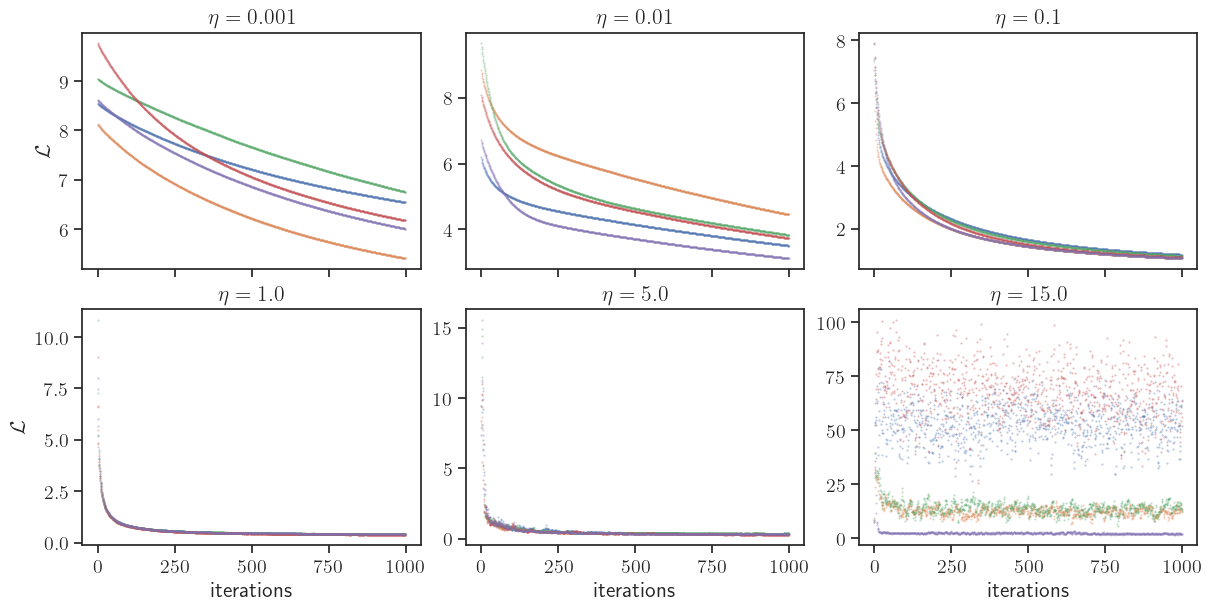

In [4]:
with h5py.File('results/mnist_lr.h5', 'r') as f :
    print(dict(f.attrs))
    print(f.attrs['lrs'])

    i_init = 6
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='constrained', sharex=True)
    axs_flat = axs.flatten()
    i_init = 0
    for i_lr, lr in enumerate(f.attrs['lrs']) :
        ax = axs_flat[i_lr]
        lr_loss = f['loss_train'][i_lr,:5,0].T
        ax.plot(lr_loss, '.', ms=1, alpha=0.4)
        # ax.plot(np.mean(lr_dists, axis=1), color='black')
        ax.set_title(f"$\eta = {f.attrs['lrs'][i_lr]}$")
    axs[1,0].set_xlabel("iterations")
    axs[1,1].set_xlabel("iterations")
    axs[1,2].set_xlabel("iterations")
    axs[0,0].set_ylabel("$\mathcal{L}$")
    axs[1,0].set_ylabel("$\mathcal{L}$")
    
    plt.savefig('figures/mnist_loss_train.png', dpi=160, bbox_inches='tight')

{'batch_size': 5000, 'epochs': 1000, 'eps': 1e-08, 'lrs': array([1.0e-03, 1.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 1.5e+01]), 'n_init': 20, 'n_pert': 10, 'train_size': 5000}
[1.0e-03 1.0e-02 1.0e-01 1.0e+00 5.0e+00 1.5e+01]


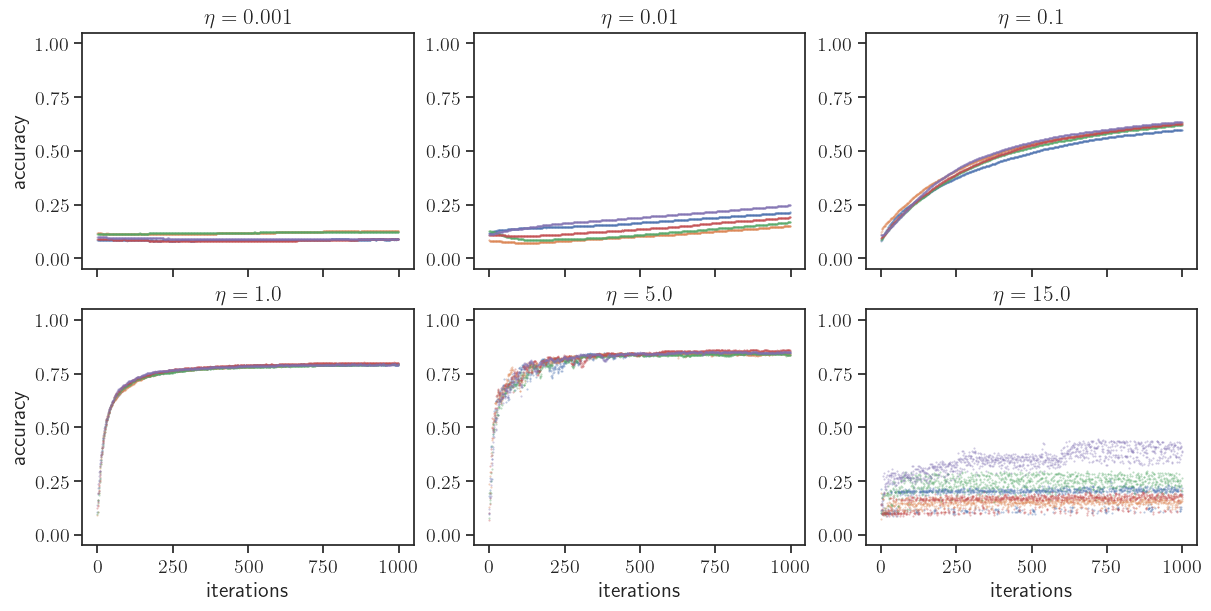

In [5]:
with h5py.File('results/mnist_lr.h5', 'r') as f :
    print(dict(f.attrs))
    print(f.attrs['lrs'])

    i_init = 6
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='constrained', sharex=True)
    axs_flat = axs.flatten()
    i_init = 0
    for i_lr, lr in enumerate(f.attrs['lrs']) :
        ax = axs_flat[i_lr]
        lr_acc = f['acc_test'][i_lr,:5,0].T
        ax.plot(lr_acc, '.', ms=1, alpha=0.4)
        # ax.plot(np.mean(lr_acc, axis=1), color='black')
        ax.set_title(f"$\eta = {f.attrs['lrs'][i_lr]}$")
        ax.set_ylim(-0.05, 1.05)
    axs[1,0].set_xlabel("iterations")
    axs[1,1].set_xlabel("iterations")
    axs[1,2].set_xlabel("iterations")
    axs[0,0].set_ylabel("accuracy")
    axs[1,0].set_ylabel("accuracy")
    
    plt.savefig('figures/mnist_accuracy_test.png', dpi=160, bbox_inches='tight')

## Independent initial conditions

{'batch_size': 5000, 'epochs': 1000, 'lrs': array([0.01, 1.  , 2.  , 5.  ]), 'n_init': 20, 'train_size': 5000}
[0.01 1.   2.   5.  ]


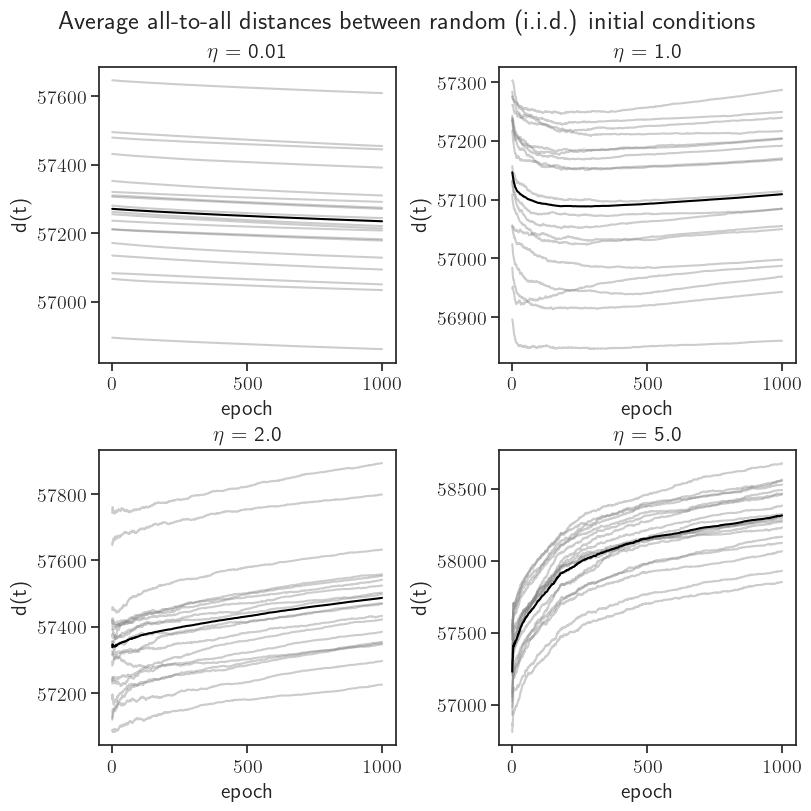

In [92]:
with h5py.File('results/mnist_random_init.h5', 'r') as f :
    print(dict(f.attrs))
    print(f.attrs['lrs'])
    
    lrs = f.attrs['lrs']
    n_init = f.attrs['n_init']
    
    # print(f['dists'].shape)
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), layout='constrained')
    axs_flat = axs.flatten()
    for i_lr, lr in enumerate(f.attrs['lrs']) :
        ax = axs_flat[i_lr]

        # Average distance to each init
        lr_dists = np.mean(f['dists'][i_lr], axis=1).T

        # Distances to single init
        lr_dists = f['dists'][i_lr, 3].T
        
        ax.plot(lr_dists, color='gray', alpha=0.4)
        ax.plot(np.mean(lr_dists, axis=1), color='black')
        ax.set_title(f"$\eta$ = {f.attrs['lrs'][i_lr]}")
        ax.set_xlabel("epoch")
        ax.set_ylabel("d(t)")
    fig.suptitle('Average all-to-all distances between random (i.i.d.) initial conditions')
    # plt.savefig('figures/mnist_dists.png', dpi=600, bbox_inches='tight')
        
    

{'batch_size': 5000, 'epochs': 1000, 'lrs': array([0.01, 1.  , 2.  , 5.  ]), 'n_init': 20, 'train_size': 5000}
[0.01 1.   2.   5.  ]


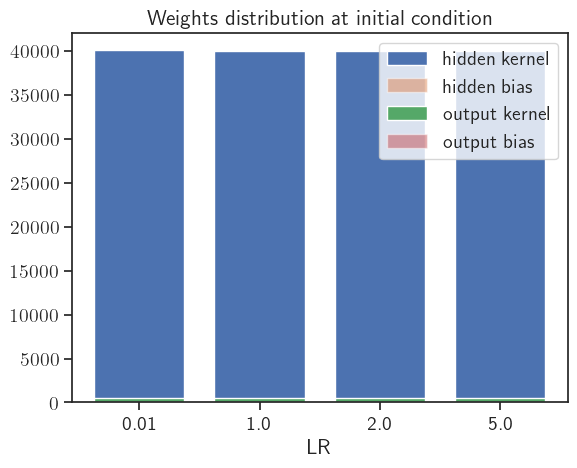

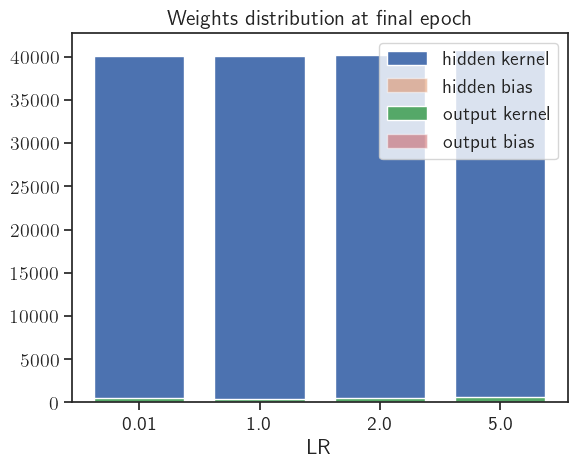

In [93]:
with h5py.File('results/mnist_random_init.h5', 'r') as f :
    print(dict(f.attrs))
    print(f.attrs['lrs'])
    
    lrs = f.attrs['lrs']
    n_init = f.attrs['n_init']

    ### Weight norms
    # plt.figure()
    # print(f['weights'].shape)
    # ws_norms = np.sum(np.abs(f['weights']), axis=(-2, -1))
    # plt.subplot(121)
    # plt.title('initial')
    # plt.hist(ws_norms[0,:,0], bins=5)
    # plt.subplot(122)
    # plt.title('final')
    # plt.hist(ws_norms[0,:,1], bins=5)

    ### Distribution between hidden / output and kernel / bias weights
    plt.figure()
    mnist_dummy = mnist_train.MNISTTrain(h_dim=[64])
    bar_width = 0.1
    r = np.linspace(0, 4*bar_width, 4)
    names = [str(lr) for lr in lrs]
    hidden_kernel_avg = np.zeros(4)
    hidden_bias_avg = np.zeros(4)
    output_kernel_avg = np.zeros(4)
    output_bias_avg = np.zeros(4)
    for i_lr, lr in enumerate(lrs) :
        for ws_matrix in f['weights'][i_lr,:,0] :    # At init
            ws_list = mnist_dummy.matrix_to_weights(ws_matrix)
            hidden_kernel_avg[i_lr] += np.sum(np.abs(ws_list[0]))
            hidden_bias_avg[i_lr] += np.sum(np.abs(ws_list[1]))
            output_kernel_avg[i_lr] += np.sum(np.abs(ws_list[2]))
            output_bias_avg[i_lr] += np.sum(np.abs(ws_list[3]))
    hidden_kernel_avg /= n_init
    hidden_bias_avg /= n_init
    output_kernel_avg /= n_init
    output_bias_avg /= n_init
    plt.bar(r, hidden_kernel_avg, edgecolor='white', width=bar_width, label='hidden kernel')
    plt.bar(r, hidden_bias_avg, alpha=0.5, edgecolor='white', width=bar_width, label='hidden bias')
    plt.bar(r, output_kernel_avg, edgecolor='white', width=bar_width, label='output kernel')
    plt.bar(r, output_bias_avg, alpha=0.5, edgecolor='white', width=bar_width, label='output bias')
    plt.xticks(r, names, fontweight='bold')
    plt.legend();
    plt.xlabel('LR')
    plt.title('Weights distribution at initial condition')

    plt.figure()
    mnist_dummy = mnist_train.MNISTTrain(h_dim=[64])
    bar_width = 0.1
    r = np.linspace(0, 4*bar_width, 4)
    names = [str(lr) for lr in lrs]
    hidden_kernel_avg = np.zeros(4)
    hidden_bias_avg = np.zeros(4)
    output_kernel_avg = np.zeros(4)
    output_bias_avg = np.zeros(4)
    for i_lr, lr in enumerate(lrs) :
        for ws_matrix in f['weights'][i_lr,:,1] :    # At init
            ws_list = mnist_dummy.matrix_to_weights(ws_matrix)
            hidden_kernel_avg[i_lr] += np.sum(np.abs(ws_list[0]))
            hidden_bias_avg[i_lr] += np.sum(np.abs(ws_list[1]))
            output_kernel_avg[i_lr] += np.sum(np.abs(ws_list[2]))
            output_bias_avg[i_lr] += np.sum(np.abs(ws_list[3]))
    hidden_kernel_avg /= n_init
    hidden_bias_avg /= n_init
    output_kernel_avg /= n_init
    output_bias_avg /= n_init
    plt.bar(r, hidden_kernel_avg, edgecolor='white', width=bar_width, label='hidden kernel')
    plt.bar(r, hidden_bias_avg, alpha=0.5, edgecolor='white', width=bar_width, label='hidden bias')
    plt.bar(r, output_kernel_avg, edgecolor='white', width=bar_width, label='output kernel')
    plt.bar(r, output_bias_avg, alpha=0.5, edgecolor='white', width=bar_width, label='output bias')
    plt.xticks(r, names, fontweight='bold')
    plt.legend();
    plt.xlabel('LR')
    plt.title('Weights distribution at final epoch')

{'batch_size': 5000, 'epochs': 1000, 'lrs': array([0.01, 1.  , 2.  , 5.  ]), 'n_init': 20, 'train_size': 5000}
[0.01 1.   2.   5.  ]
16
16


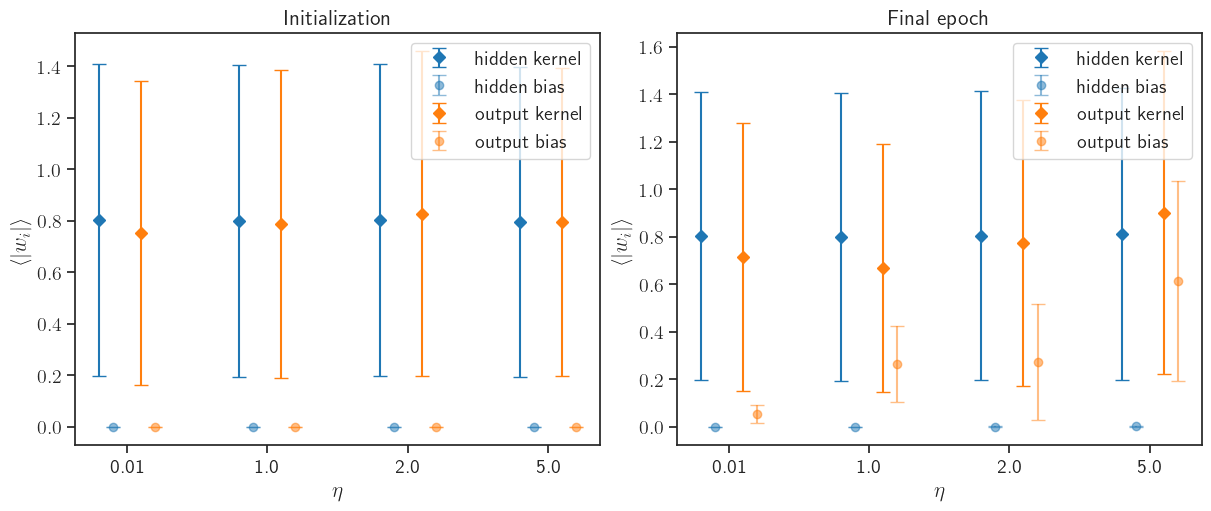

In [94]:
with h5py.File('results/mnist_random_init.h5', 'r') as f :
    print(dict(f.attrs))
    print(f.attrs['lrs'])
    
    lrs = f.attrs['lrs']
    n_init = f.attrs['n_init']
    i_init = 4

    ### Distribution between hidden / output and kernel / bias weights
    titles = ['Initialization', 'Final epoch']
    fig, axs = plt.subplots(1, 2, figsize=(12,5), layout='constrained')
    for i_ax, ax in enumerate(axs) :
        mnist_dummy = mnist_train.MNISTTrain(h_dim=[64])
        df = pd.DataFrame(np.zeros(32), index=pd.MultiIndex.from_product([lrs, ['hidden', 'output'], ['kernel', 'bias'], ['mean', 'std']], names=['lr', 'pos', 'type', 'stat']))
        for i_lr, lr in enumerate(lrs) :
            # for ws_matrix in f['weights'][i_lr,:1,1] :
            ws_list = mnist_dummy.matrix_to_weights(f['weights'][i_lr,i_init,i_ax])
            df.loc[(lr, 'hidden', 'kernel', 'mean')] = np.mean(np.abs(ws_list[0]))
            df.loc[lr, 'hidden', 'kernel', 'std'] = np.std(np.abs(ws_list[0]))
            df.loc[lr, 'hidden', 'bias', 'mean'] = np.mean(np.abs(ws_list[1]))
            df.loc[lr, 'hidden', 'bias', 'std'] = np.std(np.abs(ws_list[1]))
            df.loc[lr, 'output', 'kernel', 'mean'] = np.mean(np.abs(ws_list[2]))
            df.loc[lr, 'output', 'kernel', 'std'] = np.std(np.abs(ws_list[2]))
            df.loc[lr, 'output', 'bias', 'mean'] = np.mean(np.abs(ws_list[3]))
            df.loc[lr, 'output', 'bias', 'std'] = np.std(np.abs(ws_list[3]))        
        # hidden_kernel_avg /= n_init * mnist_dummy.INPUT_DIM * mnist_dummy.h_dim[0]
        # hidden_bias_avg /= n_init * mnist_dummy.h_dim[0]
        # output_kernel_avg /= n_init * mnist_dummy.h_dim[0] * mnist_dummy.OUTPUT_DIM
        # output_bias_avg /= n_init * mnist_dummy.OUTPUT_DIM

        colors = ['tab:blue', 'tab:orange']
        for i_lr, lr in enumerate(lrs) :
            ax.errorbar(i_lr+0.3, df.loc[lr, 'hidden', 'kernel', 'mean'], yerr=df.loc[lr, 'hidden', 'kernel', 'std'], fmt='D', capsize=5, color=colors[0], label='hidden kernel')
            ax.errorbar(i_lr+0.4, df.loc[lr, 'hidden', 'bias', 'mean'], yerr=df.loc[lr, 'hidden', 'bias', 'std'], fmt='o', capsize=5, color=colors[0], alpha=0.5, label='hidden bias')

            ax.errorbar(i_lr+0.6, df.loc[lr, 'output', 'kernel', 'mean'], yerr=df.loc[lr, 'output', 'kernel', 'std'], fmt='D', capsize=5, color=colors[1], label='output kernel')
            ax.errorbar(i_lr+0.7, df.loc[lr, 'output', 'bias', 'mean'], yerr=df.loc[lr, 'output', 'bias', 'std'], fmt='o', capsize=5, color=colors[1], alpha=0.5, label='output bias')
        
        ax.set_xticks([0.5, 1.5, 2.5, 3.5], lrs)
        ax.set_xlabel('$\eta$')
        ax.set_ylabel('$\langle |w_i| \\rangle$')

        # Legend
        handles, labels = ax.get_legend_handles_labels()
        print(len(handles))
        handles = handles[:4]
        labels = labels[:4]
        ax.legend(handles=handles, labels=labels)

        ax.set_title(titles[i_ax])

What am I trying to show with the above?
- How the weight norms change between initialization and the end of training
- How this change is distributed among hidden and output weights
- How this change is distributed among kernel and bias weights


## Test

{'batch_size': 1000, 'epochs': 30, 'eps': 1e-08, 'lr': 0.1, 'n_init': 1, 'n_pert': 1, 'train_size': 1000}
(1, 1, 2, 2, 850, 74)
Norm of ref at init: 40593.993157746365
Norm of ref at final: 40588.08647857001
Norm of difference of ref between final and init: 210.54601250418278

Distances between ref and pert
[2.51072383e-04 0.00000000e+00 3.15009680e-06 0.00000000e+00]
[2.51074589e-04 1.45047715e-08 3.06202131e-06 5.62266942e-09]
[1.00000879        inf 0.97204039        inf]
[0.00025422 0.00025422 0.00025421 0.0002542  0.0002542  0.0002542
 0.00025419 0.00025419 0.00025419 0.00025418 0.00025418 0.00025418
 0.00025418 0.00025418 0.00025417 0.00025417 0.00025417 0.00025417
 0.00025417 0.00025417 0.00025417 0.00025416 0.00025416 0.00025416
 0.00025416 0.00025416 0.00025416 0.00025416 0.00025416 0.00025416]
Number of weights: 50816


/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_59792/4079345082.py:26: RuntimeWarning: divide by zero encountered in divide
  print(ws_list_dists_final / ws_list_dists_init)


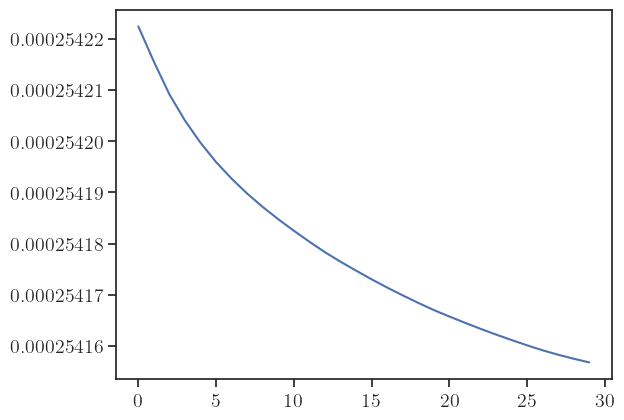

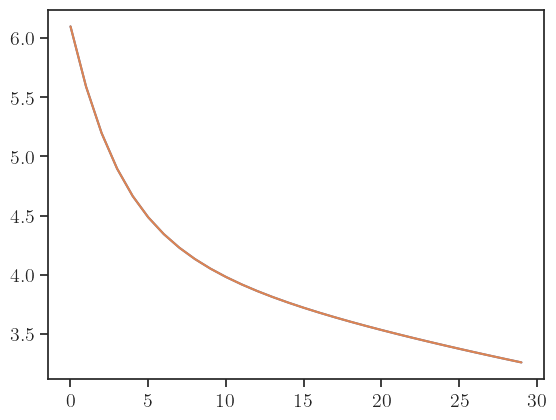

In [46]:
with h5py.File('results/mnist_test.h5', 'r') as f :
    print(dict(f.attrs))
    print(f['weights'].shape)
    
    # print(f['weights'][...,0,1,:,:])
    # print(f['weights'][...,1,1,:,:])
    print(f"Norm of ref at init: {np.sum(np.abs(f['weights'][...,0,0,:,:]))}")
    print(f"Norm of ref at final: {np.sum(np.abs(f['weights'][...,0,1,:,:]))}")
    print(f"Norm of difference of ref between final and init: {np.sum(np.abs(f['weights'][...,0,0,:,:] - f['weights'][...,0,1,:,:]))}")
    # print(np.sum(np.isclose(f['weights'][...,1,0,:,:], 0, atol=0.01, rtol=0)))
    # print(np.sum(np.isclose(f['weights'][...,1,1,:,:], 0, atol=0.01, rtol=0)))
    
    # Check distribution of distances across weights
    mnist_dummy = mnist_train.MNISTTrain([64])
    ws_list_ref_1 = mnist_dummy.matrix_to_weights(f['weights'][0,0,0,0,:,:])
    ws_list_ref_2 = mnist_dummy.matrix_to_weights(f['weights'][0,0,0,1,:,:])
    ws_list_pert_1 = mnist_dummy.matrix_to_weights(f['weights'][0,0,1,0,:,:])
    ws_list_pert_2 = mnist_dummy.matrix_to_weights(f['weights'][0,0,1,1,:,:])
    
    ws_list_dists_init = np.array([np.sum(np.abs(ws2 - ws1)) for ws1, ws2 in zip(ws_list_ref_1, ws_list_pert_1)])
    ws_list_dists_final = np.array([np.sum(np.abs(ws2 - ws1)) for ws1, ws2 in zip(ws_list_ref_2, ws_list_pert_2)])

    print("\nDistances between ref and pert")
    print(ws_list_dists_init)
    print(ws_list_dists_final)
    print(ws_list_dists_final / ws_list_dists_init)

    # print(np.array([np.sum(np.abs(ws2 - ws1)) for ws1, ws2 in zip(ws_list_ref_1, ws_list_ref_2)]))
    
    
    dists = f['dists'][0,0,0]
    print(dists)
    N_16 = 784 * 16 + 16 + 16 * 10 + 10
    N_64 = 784 * 64 + 64 + 64 * 10 + 10
    # plt.plot(dists / N_64)

    plt.plot(dists)

    print(f"Number of weights: {np.sum(f['weights'][0,0,0,0] != 0)}")

    plt.figure()
    plt.plot(f['loss_train'][0,0].T)

Most of the distance comes from the hidden layer weights.

The ratio of increase of distances is of roughly the same order for both hidden and output weights, slightly higher from hidden. But likely this is not the major source of complexity.

In [42]:
init = mnist_dummy.get_random_init()
print(init[0])
pert = mnist_dummy.pert_uniform(init, 0)
print(pert[0])

assert np.all(init[0] == pert[0])

mnist_train.get_dist(init, pert)

[[-0.72167234  0.72700333 -0.536758   ...  0.83242622 -1.97104094
  -0.13725185]
 [-0.63033789 -2.21455278  0.44940487 ...  0.24553371 -0.79124427
   0.35502024]
 [ 0.28206797 -1.6561804  -0.09980577 ... -0.46332937  1.16707013
  -0.68644367]
 ...
 [-1.45811911  0.98163491 -0.49664692 ... -1.75535067 -0.52888068
   1.26023596]
 [-0.54282362 -0.2932416  -0.37605196 ... -0.64736824  0.21501181
   0.41569222]
 [ 0.74738949 -0.54432984 -1.50893054 ...  0.75818518 -0.32737716
   2.01632821]]
[[-0.72167234  0.72700333 -0.536758   ...  0.83242622 -1.97104094
  -0.13725185]
 [-0.63033789 -2.21455278  0.44940487 ...  0.24553371 -0.79124427
   0.35502024]
 [ 0.28206797 -1.6561804  -0.09980577 ... -0.46332937  1.16707013
  -0.68644367]
 ...
 [-1.45811911  0.98163491 -0.49664692 ... -1.75535067 -0.52888068
   1.26023596]
 [-0.54282362 -0.2932416  -0.37605196 ... -0.64736824  0.21501181
   0.41569222]
 [ 0.74738949 -0.54432984 -1.50893054 ...  0.75818518 -0.32737716
   2.01632821]]


0.0